In [32]:
import sys
sys.path.insert(0, '../util')
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
from sc import *
from plot import *
from tqdm import tqdm
from alg import hstar, k_rollout, bhattacharya, almost_equal
from pqdict import pqdict
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# make scs

In [2]:
def generate_hole_sc(num_holes, hole_radius, border_eps, prox_eps, seed=1, max_iter = 1000):
    num_side = 17
    top, left, height, width = 1, -1, 2, 2

    # Initialize Simplicial Complex (SC)
    SC = SimplicialComplex(num_side, False, False, True)

    rng = np.random.Generator(np.random.PCG64(seed))
    centers = []
    bound = 1 - hole_radius - border_eps
    for k in range(num_holes):
        found_one, i = False, -1
        while (not found_one) and (i < max_iter):
            if i == max_iter:
                print(f"Max iter reached with {k} holes added. Change hole params!!")
                break
            i += 1
            x = np.round(rng.uniform(-bound, bound, 2), 1)

            if k == 0:
                centers.append(x)
                break
            
            too_close = False
            for y in centers:
                center_dist = np.linalg.norm(x-y, ord=np.inf)
                if (center_dist < hole_radius + prox_eps):
                    too_close = True
            if not too_close:
                centers.append(x)
                found_one = True

    centers = np.array(centers)
    centers -= np.mean(centers, axis=0)

    SC.make_holes(centers, hole_radius)

    return SC, centers

In [17]:
seed, hole_radius, border_eps, prox_eps = 12, 0.12, 0.12, 0.3
_, hole_locs_i = generate_hole_sc(9, hole_radius, border_eps, prox_eps, seed, 2000)
hole_locs = np.vstack([hole_locs_i, [-0.4, 0]])

sorted_idx = np.argsort(np.linalg.norm(hole_locs, 2, 1))
hole_locs = hole_locs[sorted_idx]
hole_locs[-1,:] = [-0.25, -0.7]

folder = "../exp2_data"

In [12]:
SCs = []
ref_outputs = []
coords = np.array([(-1,-1), (1, -1), (1, -0.7), (-1,0.7), (0,1), (1,1)])

for i in range(0, 10):
    num_side = 20
    SC_i = SimplicialComplex(num_side, False, False, True)
    all_faces = np.arange(SC_i.face_vec.shape[0])
    faces_to_add = {2:set(all_faces)}
    SC_i.add_simplices(faces_to_add)
    SC_i.make_holes(hole_locs[:i+1,:], hole_radius)
    ref_out = Path(SC_i, path_from_coords(SC_i, coords))
    SCs.append(SC_i)
    ref_outputs.append(ref_out)

In [13]:
hole_locs

array([[ 2.77555756e-17,  5.55555556e-02],
       [-4.00000000e-01,  0.00000000e+00],
       [ 2.77555756e-17,  5.55555556e-01],
       [ 6.00000000e-01, -4.44444444e-02],
       [ 2.00000000e-01, -6.44444444e-01],
       [ 5.00000000e-01,  4.55555556e-01],
       [-6.00000000e-01, -5.44444444e-01],
       [-5.00000000e-01,  6.55555556e-01],
       [ 7.00000000e-01, -5.44444444e-01],
       [-2.50000000e-01, -7.00000000e-01]])

<AxesSubplot:>

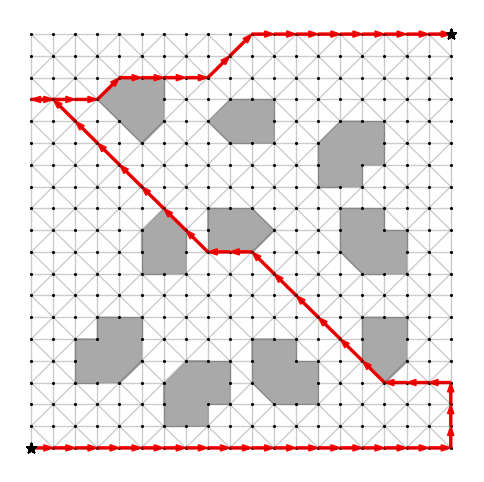

In [14]:
plot_path(SCs[-1], ref_outputs[-1], 'red', '')

In [19]:
alphas = np.linspace(0, 3, 20)
np.savez(f"{folder}/setup", alphas=alphas, SCs=SCs, ref_outputs=ref_outputs, hole_locs=hole_locs)

# Get data

In [20]:
results_dict = np.load(f"{folder}/setup.npz", allow_pickle=True)
alphas, SCs, ref_outputs, hole_locs = [results_dict[x] for x in results_dict.keys()]

In [64]:
eps = 1e-4
num_SCs = len(SCs)
# inputs1 = [(x[0], x[1], x[2], alphas, 0, False, eps, folder) for x in zip(range(len(SCs)), SCs, ref_outputs)]
# inputs2 = [(x[0], x[1], x[2], alphas, 1, False, eps, folder) for x in zip(range(len(SCs)), SCs, ref_outputs)]
# inputs3 = [(x[0], x[1], x[2], alphas, 1, True,  eps, folder) for x in zip(range(len(SCs)), SCs, ref_outputs)]
inputs1 = [(x[0], x[1], x[2], alphas, 0, False, eps, folder) for x in zip([num_SCs-1], [SCs[-1]], [ref_outputs[-1]])]
inputs2 = [(x[0], x[1], x[2], alphas, 1, False, eps, folder) for x in zip([num_SCs-1], [SCs[-1]], [ref_outputs[-1]])]
inputs3 = [(x[0], x[1], x[2], alphas, 1, True,  eps, folder) for x in zip([num_SCs-1], [SCs[-1]], [ref_outputs[-1]])]

In [65]:
from wrapper import exp2_wrapper as wrap

In [66]:
# Base heuristic 
pool = Pool(4)
res = pool.map_async(wrap, inputs1).get()
pool.terminate()

100%|███| 20/20 [00:03<00:00,  5.18it/s]


In [ ]:
# One step lookahead no pruning
pool = Pool(4)
res = pool.map_async(wrap, inputs2).get()
pool.terminate()

 15%|▌   | 3/20 [01:31<08:48, 31.09s/it]

In [ ]:
# One step lookahead w/ pruning
pool = Pool(4)
res = pool.map_async(wrap, inputs3).get()
pool.terminate()

100%|███| 20/20 [04:06<00:00, 12.32s/it]


In [29]:
from wrapper import bhattacharya_wrapper as bhat_wrap

bhat_inputs = []
for i, (SC, ref_path, locs) in tqdm(enumerate(zip(SCs, ref_outputs, hole_locs))):
    start, end = ref_path[0], ref_path[-1]
    bhat_inputs.append([SC, ref_path, start, end, 1e-7, True, i, folder])

10it [00:00, 47825.59it/s]


In [30]:
pool = Pool(processes=4)
data_bhat = pool.starmap(bhat_wrap, [bhat_inputs[-1]])
pool.terminate()

/Users/ctaveras/opt/anaconda3/envs/ot-simp/lib/python3.9/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


# Process Data

In [68]:
folder = "../exp2_data"
results_dict = np.load(f"{folder}/setup.npz", allow_pickle=True)
alphas, SCs, ref_outputs, hole_locs = [results_dict[x] for x in results_dict.keys()]

data_reg   = [np.load(f"{folder}/data_steps0_batch{i}.npz", allow_pickle=True)["data"] for i in range(10)]
data_roll  = [np.load(f"{folder}/data_steps1_batch{i}.npz", allow_pickle=True)["data"] for i in range(10)]
data_prune = [np.load(f"{folder}/data_prune_steps1_batch{i}.npz", allow_pickle=True)["data"] for i in range(10)]
data_bhat  = [np.load(f"{folder}/data_bhat_batch_{i}.npz", allow_pickle=True)["data"] for i in range(10)]

In [69]:
def get_transitions(path_arr, ref_proj):
    proj_arr = np.array([np.linalg.norm(x.proj - ref_proj, 2) for x in path_arr])
    proj_grad = proj_arr[:-1] - proj_arr[1:]
    transitions = np.where(proj_grad > 0)[0] + 1
    return np.append([0], transitions)

def identify_class(heuristic_paths, bhat_paths, eps=1e-5):
    corresponding_shortest = []
    for i, path_i in enumerate(heuristic_paths):
        for j, path_j in enumerate(bhat_paths):
            if almost_equal(path_i.proj, path_j.proj, eps):
                corresponding_shortest.append(path_j)
                break
    return corresponding_shortest

def get_best_paths(paths, bounds, num_visited, eps=1e-5):
    best_paths, best_idxs = [], []
    path_lens = [x.weight for x in paths]
    for i in range(len(bounds)):
        left = bounds[i]
        right = len(paths) if i == len(bounds) - 1 else bounds[i+1]
        sub_arr = path_lens[left:right]
        best_idx = left+np.argmin(sub_arr)
        best_cost = path_lens[best_idx]
        all_nodes_w_best_cost = np.array([(left+i, num_visited[left+i]) for (i, x) in enumerate(sub_arr) if np.abs(best_cost - x) < eps])
        best_idx = all_nodes_w_best_cost[np.argmin(all_nodes_w_best_cost[:,1]),0]
        best_path = paths[best_idx]
        best_paths.append(best_path)
        best_idxs.append(best_idx)

    return best_paths, best_idxs

def assign_colors_to_paths(paths1, paths2, paths3, colors, decimals):
    paths = paths1 + paths2 + paths3
    color_dict = {}
    k = 1
    assigned_colors = [None] * len(paths)
    for i, x in enumerate(paths):
        proj_x = tuple(np.round(x.proj, decimals))
        if proj_x in color_dict:
            assigned_colors[i] = color_dict[proj_x]
        if proj_x not in color_dict:
            k += 1
            color_dict[proj_x] = colors[k]
            assigned_colors[i] = colors[k]

    n1, n2, n3 = len(paths1), len(paths2), len(paths3)

    path1_colors = colors[:2] + assigned_colors[:n1]
    path2_colors = colors[:2] + assigned_colors[n1:n1+n2]
    path3_colors = colors[:2] + assigned_colors[n1+n2:]

    return path1_colors, path2_colors, path3_colors, color_dict

In [70]:
num_SCs = len(SCs)
data_to_plot = np.zeros((num_SCs, 4, 3), object)

for i, (SC, ref_path_arr)  in enumerate(zip(SCs, ref_outputs)):
    ref_path = Path(SC, ref_path_arr)
    ref_proj = ref_path.proj

    for j in range(3):
        print(f"--"*(j+1))
        alphas_j = alphas
        data_ij = (data_reg[i]) if (j == 0) else (data_roll[i] if (j == 1) else data_prune[i])
        paths_ij = [data_ij[k][0] for k in range(len(data_ij))]
        path_proj_diffs = [np.linalg.norm((Path(SC, x) - ref_path).proj) for x in paths_ij]            
        num_visited_ij = data_ij[:,-1]
        print([x.proj.shape for x in paths_ij])
        def get_transitions2(path_arr, ref_proj):
            print([x.proj.shape for x in path_arr])
            proj_arr = np.array([np.linalg.norm(x.proj - ref_proj, 2) for x in path_arr])
            proj_grad = proj_arr[:-1] - proj_arr[1:]
            transitions = np.where(proj_grad > 0)[0] + 1
            return np.append([0], transitions)
        trans_ij = get_transitions2(paths_ij, ref_proj)
        best_paths_ij, best_paths_idx = get_best_paths(paths_ij, trans_ij, num_visited_ij)
        best_data = [(alphas_j[k], np.round(paths_ij[k].weight, 2), np.round(path_proj_diffs[k], 2), data_ij[k][-1]) for k in best_paths_idx]
        data_to_plot[i,j,0] = data_ij[best_paths_idx[-1]][-1]
        data_to_plot[i,j,1] = paths_ij[best_paths_idx[-1]].weight
        data_to_plot[i,j,2] = paths_ij[best_paths_idx[-1]]
    data_to_plot[i,3,0] = data_bhat[i][-1]
    data_to_plot[i,3,1] = data_bhat[i][0].weight
    data_to_plot[i,3,2] = data_bhat[i][0]

colors = [plt.cm.Set1(i) for i in range(20)]

--
[(1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,)]
[(1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,)]
----
[(1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,)]
[(1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,)]
------
[(1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,)]
[(1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,)]
--
[(2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,)]
[(2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,)]
----
[(2,), (2

 20%|▊   | 4/20 [02:06<08:43, 32.75s/it]

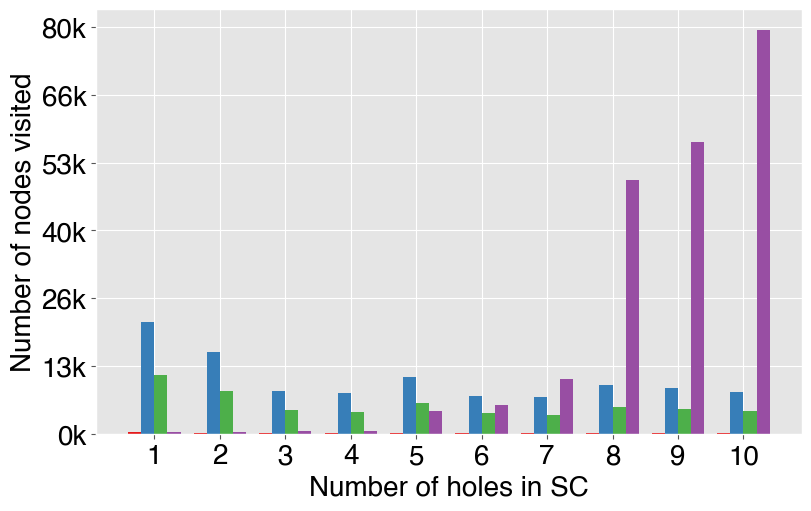

 30%|█▏  | 6/20 [03:08<07:20, 31.46s/it]

In [72]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

matplotlib.style.use('ggplot')

width = 0.2
x = np.arange(1,1+num_SCs) - 1.5 * width
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(8,5))

labels = ["heuristic", "heuristic w/ rollout", "heuristic w/ rollout & pruning", "Bhattacharya et al."]
for i in range(4):
    measurement = data_to_plot[i,]
    offset = width * multiplier
    rects = ax.bar(x + offset, data_to_plot[:,i,0], width, label=labels[i], color=colors[i])
    multiplier += 1

font = {'family': 'Helvetica',
    'color':  'black',
    'weight': 'normal',
    'size': 20}

plt.rcParams.update({
"text.usetex": False,
"font.family": "sans-serif",
"font.sans-serif": ["Helvetica"]})

ax.set_xlabel("Number of holes in SC", fontdict=font)
ax.set_ylabel("Number of nodes visited",  fontdict=font)
ax.set_xticks(np.arange(1,11))
ax.set_xticklabels([str(i) for i in range(1, 11)], fontdict=font)
yticks = np.linspace(0, 80000, 7)
ax.set_yticks(yticks)
ax.set_yticklabels([str(int(i/1000)) + 'k'  for i in yticks], fontdict=font)
plt.show()

In [74]:
data_to_plot

array([[[284, 3.260059236681804,
         0-20-41-62-83-103-123-143-163-183-203-224-245-266-287-308-329-350-371-392-393-394-395-396-397-398-399],
        [22078, 3.1367357761287717,
         0-20-40-60-80-100-121-142-163-184-205-226-247-248-249-250-251-272-293-314-335-356-377-398-399],
        [11563, 3.1367357761287717,
         0-20-40-60-80-100-121-142-163-184-205-226-247-248-249-250-251-272-293-314-335-356-377-398-399],
        [251, 3.075074045852255,
         0-1-22-43-64-85-106-127-148-168-188-208-228-249-270-291-312-333-354-375-396-397-398-399]],

       [[213, 3.0134123155757386,
         0-20-41-62-83-104-125-146-167-187-207-228-229-230-251-272-293-314-335-356-377-398-399],
        [16106, 3.0134123155757386,
         0-20-41-62-83-104-125-146-167-187-207-228-249-270-291-292-293-314-335-356-377-398-399],
        [8501, 3.075074045852255,
         0-1-22-43-64-85-105-125-146-167-187-207-228-249-270-291-292-293-314-335-356-377-398-399],
        [247, 3.075074045852255,
        